In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller1 import player_controller
from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [25]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [26]:
best_solutions_a = pd.read_csv('best_solutions_a.csv')
best_solutions_b = pd.read_csv('best_solutions_b.csv')

In [27]:
results_a = pd.read_csv('results_a.csv')
results_b = pd.read_csv('results_b.csv')

In [28]:
# Concatenate dataframes (stack them)
final_results = pd.concat([results_a, results_b])

In [45]:
final_results.describe()

,Enemy,Run,Generation,Mean Fitness,Max Fitness
count,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000
mean,1.871795,5.384615,15.500000,77.083481,94.421408
std,0.790478,2.816449,8.657291,17.222548,0.619475
min,1.000000,1.000000,1.000000,6.591409,91.306268
25%,1.000000,3.000000,8.000000,69.391043,94.319827
50%,2.000000,5.000000,15.500000,82.458653,94.361645
75%,3.000000,8.000000,23.000000,89.563201,95.051240
max,3.000000,10.000000,30.000000,94.202923,95.072746


In [30]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = final_results.groupby(['Algorithm', 'Enemy', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std'),
).reset_index()

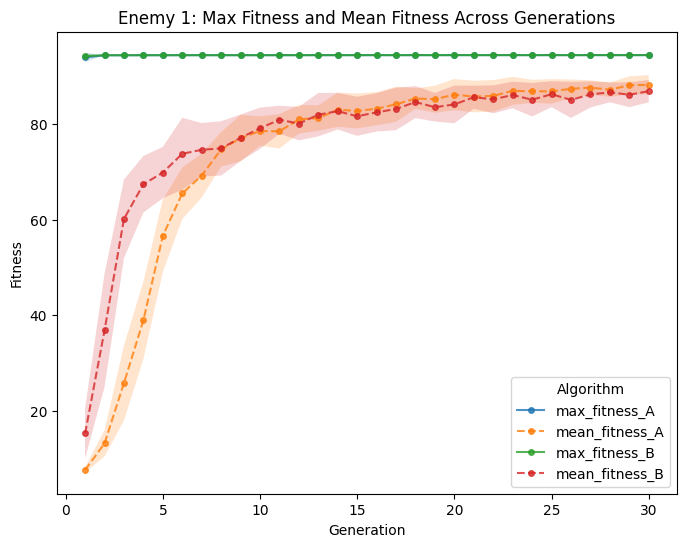

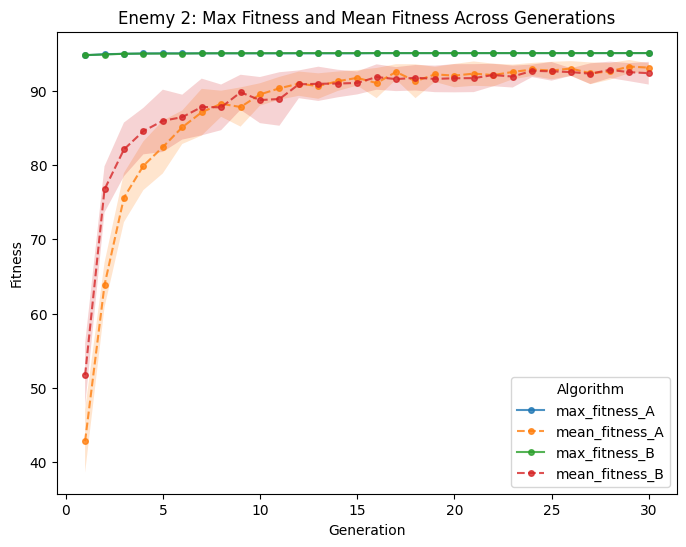

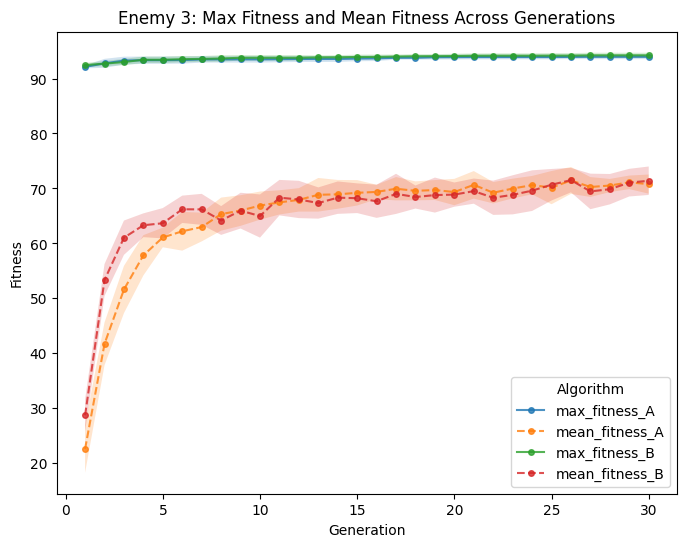

In [31]:
enemies = [1,2,3]
for enemy in enemies:
    plt.figure(figsize=(8, 6))
    data_enemy = grouped[grouped['Enemy'] == enemy]

    algorithms = data_enemy['Algorithm'].unique()

    for algorithm in algorithms:
        data_alg = data_enemy[data_enemy['Algorithm'] == algorithm]

        # Max Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['max_fitness_mean'], 
            label=f'max_fitness_{algorithm}', 
            marker='o',
            markersize=4,
            alpha = 0.8
        )
        # Max Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['max_fitness_mean'] - data_alg['max_fitness_std'],
            data_alg['max_fitness_mean'] + data_alg['max_fitness_std'],
            alpha=0.2
        )
        
        # Mean Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['mean_fitness_mean'], 
            label=f'mean_fitness_{algorithm}', 
            marker='o', 
            linestyle='--',
            markersize=4,
            alpha = 0.8
        )

        # Mean Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['mean_fitness_mean'] - data_alg['mean_fitness_std'],
            data_alg['mean_fitness_mean'] + data_alg['mean_fitness_std'],
            alpha=0.2
        )

    plt.title(f'Enemy {enemy}: Max Fitness and Mean Fitness Across Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')

    plt.legend(title='Algorithm')

    plt.show()

In [32]:
def parse_solution_string(solution_string):
    cleaned_string = solution_string.replace('[', '').replace(']', '').replace(',', ' ')
    return list(map(float, cleaned_string.split()))


final_results['Best Solution'] = final_results['Best Solution'].apply(parse_solution_string)
best_solutions_per_enemy = final_results.groupby(['Algorithm', 'Enemy'])['Best Solution'].max()
print(best_solutions_per_enemy)

Algorithm  Enemy
A          1        [0.92670531, 0.7371775, 0.75714891, -0.1589822...
           2        [0.03890155, -0.84030616, -0.62337265, 0.35729...
           3        [0.947946629, 0.375923127, -0.134611242, -0.81...
B          1        [0.95790577, -0.5083281, 0.10536807, 0.6723911...
           2        [0.999076454, -0.182968254, 0.469539355, -0.83...
           3        [0.78002325, -0.97466493, 0.54931998, -0.52277...
Name: Best Solution, dtype: object


In [34]:
def calculate_gain(solution, enemy, experiment_name, n_hidden_neurons_1, n_hidden_neurons_2, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    solution = np.array(solution)
    
    # Initialize the environment
    env = Environment(
        experiment_name=experiment_name,
        enemies=[enemy],
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
        enemymode="ai",
        level=2,
        speed="fastest",
        visuals=False
    )
    
    gains = []
    for _ in range(num_tests):
        env.player_controller.set(solution, env.get_num_sensors())
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    
    return gains


In [35]:
results = []

for (algorithm, enemy), solution in best_solutions_per_enemy.items():
    experiment_name_gain = f'gains_{algorithm}_enemy_{enemy}'
    gains = calculate_gain(solution, enemy, experiment_name_gain, n_hidden_neurons_1=10, n_hidden_neurons_2=5, num_tests=5)
    
    for gain in gains:
        results.append({
            'Algorithm': algorithm,
            'Enemy': enemy,
            'Gain': gain
        })

results_df = pd.DataFrame(results)
results_df.to_csv('gains_per_enemy.csv', index=False)


MESSAGE: Pygame initialized for simulation.
Gain: 100.0000
Gain: 64.0000
Gain: 70.0000
Gain: 34.0000
Gain: 100.0000

MESSAGE: Pygame initialized for simulation.
Gain: 100.0000
Gain: 100.0000
Gain: 62.0000
Gain: 100.0000
Gain: 100.0000

MESSAGE: Pygame initialized for simulation.
Gain: 74.0000
Gain: 62.0000
Gain: 40.0000
Gain: 20.0000
Gain: 10.0000

MESSAGE: Pygame initialized for simulation.
Gain: 46.0000
Gain: 46.0000
Gain: 64.0000
Gain: 40.0000
Gain: 52.0000

MESSAGE: Pygame initialized for simulation.
Gain: 100.0000
Gain: 90.0000
Gain: 82.0000
Gain: 92.0000
Gain: 88.0000

MESSAGE: Pygame initialized for simulation.
Gain: 54.0000
Gain: 76.0000
Gain: 94.0000
Gain: 16.0000
Gain: 20.0000


<Figure size 1000x600 with 0 Axes>

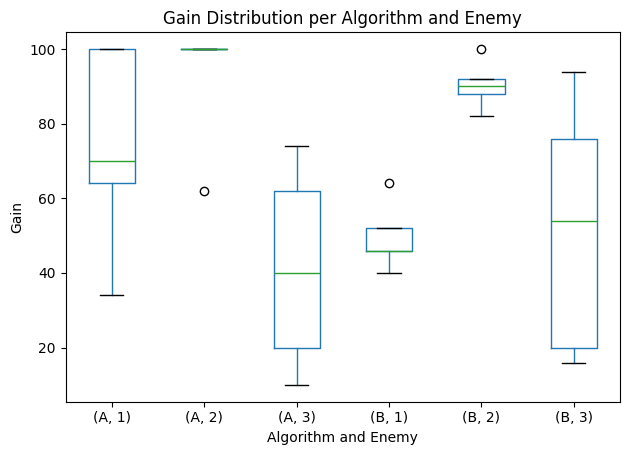

In [37]:
# Create a boxplot for the gains
plt.figure(figsize=(10, 6))
results_df.boxplot(column='Gain', by=['Algorithm', 'Enemy'], grid=False)

# Set plot labels and title
plt.title('Gain Distribution per Algorithm and Enemy')
plt.suptitle('') 
plt.xlabel('Algorithm and Enemy')
plt.ylabel('Gain')

# Display the plot
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
results_df

,Algorithm,Enemy,Gain
0,A,1,100
1,A,1,64
2,A,1,70
3,A,1,34
4,A,1,100
5,A,2,100
6,A,2,100
7,A,2,62
8,A,2,100
9,A,2,100


In [54]:
for enemy in enemies:
    # Extract gains for each algorithm
    gains_a = results_df[(results_df['Enemy'] == enemy) & (results_df['Algorithm'] == 'A')]['Gain']
    gains_b = results_df[(results_df['Enemy'] == enemy) & (results_df['Algorithm'] == 'B')]['Gain']
    
    # Perform t-test
    if gains_a.empty or gains_b.empty:
        print(f"\nNot enough data to perform tests for Enemy {enemy}.")
        continue
    
    t_stat, p_val_t = ttest_ind(gains_a, gains_b, equal_var=False)
    
    # Perform Mann-Whitney U test
    u_stat, p_val_u = mannwhitneyu(gains_a, gains_b, alternative='two-sided')
    
    print(f"\nStatistical Test Results for Enemy {enemy}:")
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_val_t:.4f}")
    print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_val_u:.4f}")
    
    if p_val_t < 0.05:
        print("Result: Significant difference in mean gains (t-test).")
    else:
        print("Result: No significant difference in mean gains (t-test).")
        
    if p_val_u < 0.05:
        print("Result: Significant difference in mean gains (Mann-Whitney U test).")
    else:
        print("Result: No significant difference in mean gains (Mann-Whitney U test).")



Statistical Test Results for Enemy 1:
T-test: t-statistic = 1.8411, p-value = 0.1267
Mann-Whitney U test: U-statistic = 19.5, p-value = 0.1706
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).

Statistical Test Results for Enemy 2:
T-test: t-statistic = 0.2456, p-value = 0.8155
Mann-Whitney U test: U-statistic = 18.0, p-value = 0.2652
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).

Statistical Test Results for Enemy 3:
T-test: t-statistic = -0.5541, p-value = 0.5954
Mann-Whitney U test: U-statistic = 9.5, p-value = 0.6004
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).
